https://scholar.google.com/scholar?start=0&hl=en&as_sdt=80005&sciodt=0,11&cites=3033757799749220519&scipsc=

https://arxiv.org/pdf/2006.05861.pdf


http://cimalab.intec.co/applications/thyroid/

# self attention

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [2]:
!ls ../data/

benign	malign


In [19]:
import re
import xml.etree.ElementTree as ET

features = []
for t_type in ['benign', 'malign']:
  files = os.listdir("../data/"+t_type+"/")
  for i in range(len(files)):
    root = ET.parse("../data/"+t_type+"/" + files[i] + "/" + files[i] + ".xml").getroot()
    feature = []
    for x in root:
        #print(x.tag, x.text)
        for y in x:
          if(y.tag=="svg"):
            t = str(y.text)
        if(x.tag=='composition'):
          feature.append(x.text)
        if(x.tag=='echogenicity'):
          feature.append(x.text)
        if(x.tag=='margins'):
          feature.append(x.text)
        if(x.tag=='calcifications'):
          feature.append(x.text)
    shapes = re.findall(r"\[.*?]", t[1:])
    #print(files[i])
    #im = cv2.imread("./"+t_type+"/" + files[i] + "/" + files[i] + ".jpg")
    #if im is not None:
    #  plt.figure(figsize=(10, 10))
    #  plt.imshow(im)
    shape_list = []
    for s in shapes:
        xs = re.findall(r"\"x\":.[0-9]+", s)
        xs = [int(x.split(':')[1]) for x in xs]
        ys = re.findall(r"\"y\":.[0-9]+", s)
        ys = [int(y.split(':')[1]) for y in ys]
        shape_list.append(xs)
        shape_list.append(ys)
    feature.append(t_type)
    feature.append(shape_list)

    im_name = "../data/"+t_type+"/" + files[i] + "/" + files[i] + ".jpg"
    im = cv2.imread(im_name)
    feature.append(im)

    
    features.append(feature)
    
    


    


In [21]:
f = np.array(features)
for i in range(len(features)):
  for j in range(4):
    if(f[i, j]==None):
      f[i, j] = 'Unknown'
#for i in range(len(features)):
#  print(len(features[i][4]))

compositions = np.unique(f[:, 0])
echogenicity = np.unique(f[:, 1])
margins = np.unique(f[:, 2])
calcifications = np.unique(f[:, 3])
label = np.unique(f[:, 4])

/home/mihail/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [22]:
print(compositions)
print(echogenicity)
print(margins)
print(calcifications)
print(label)

print(len(features))


['Unknown' 'cystic' 'predominantly solid' 'solid' 'spongiform appareance']
['Unknown' 'hyperechogenecity' 'hypoechogenecity' 'isoechogenicity'
 'marked hypoechogenecity']
['Unknown' 'ill- defined' 'microlobulated' 'spiculated'
 'well defined smooth']
['macrocalcification' 'microcalcification' 'non']
['benign' 'malign']
98


In [23]:
_1 = np.reshape(np.array([np.where(f[i, 0]==compositions)[0][0] for i in range(len(features))]), (-1, 1))
_2 = np.reshape(np.array([np.where(f[i, 1]==echogenicity)[0][0] for i in range(len(features))]), (-1, 1))
_3 = np.reshape(np.array([np.where(f[i, 2]==margins)[0][0] for i in range(len(features))]), (-1, 1))
_4 = np.reshape(np.array([np.where(f[i, 3]==calcifications)[0][0] for i in range(len(features))]), (-1, 1))
_5 = np.reshape(np.array([np.where(f[i, 4]==label)[0][0] for i in range(len(features))]), (-1, 1))


feature_vec = np.concatenate((_1, _2, _3, _4), axis=1)
labels = _5




In [24]:
np.save('features.npy', features)
np.save('labels.npy', labels)


/home/mihail/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder().fit(feature_vec)

features_onehot = ohe.transform(feature_vec)

#ohe.get_feature_names()

[Text(188.333,481.775,'X[17] <= 0.5\ngini = 0.45\nsamples = 73\nvalue = [25, 48]\nclass = malign'),
 Text(94.1667,344.125,'gini = 0.0\nsamples = 37\nvalue = [0, 37]\nclass = malign'),
 Text(282.5,344.125,'X[3] <= 0.5\ngini = 0.424\nsamples = 36\nvalue = [25, 11]\nclass = benign'),
 Text(188.333,206.475,'gini = 0.0\nsamples = 19\nvalue = [19, 0]\nclass = benign'),
 Text(376.667,206.475,'X[6] <= 0.5\ngini = 0.457\nsamples = 17\nvalue = [6, 11]\nclass = malign'),
 Text(282.5,68.825,'gini = 0.337\nsamples = 14\nvalue = [3, 11]\nclass = malign'),
 Text(470.833,68.825,'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = benign')]

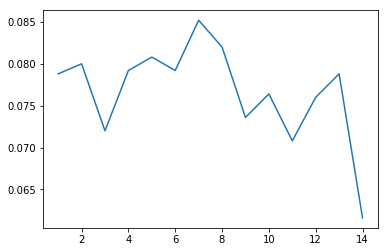

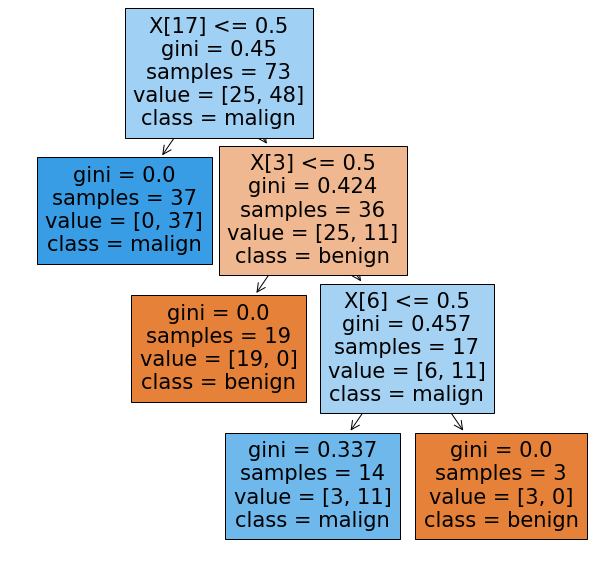

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

errors = []
for leaf_nodes in range(1, 15):
  e = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(features_onehot, labels)
    estimator = DecisionTreeClassifier(max_leaf_nodes=4)
    estimator.fit(X_train, y_train)
    y_prediction = estimator.predict(X_test)
    #print(y_test.squeeze())
    #print(y_prediction)

    error = (np.abs(y_test.squeeze() - y_prediction)>0).astype(int)
    e.append(np.sum(error)/np.size(y_prediction))
  average_error = np.mean(e)
  errors.append(average_error)


plt.figure()
plt.plot(np.array(list(range(1, 15))), errors)


from sklearn.tree import plot_tree

plt.figure(figsize=(10, 10))
plot_tree(estimator, class_names=['benign', 'malign'], filled=True)


In [10]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.3.
The scikit-learn version is 0.24.2.


In [11]:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()


The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 17] <= 0.5 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 3] <= 0.5 else to node 4.
		node=3 leaf node.
		node=4 test node: go to node 5 if X[:, 6] <= 0.5 else to node 6.
			node=5 leaf node.
			node=6 leaf node.



In [12]:

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 1
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Rules used to predict sample 1: 
decision id node 0 : (X_test[1, 17] (= 1.0) > 0.5)
decision id node 2 : (X_test[1, 3] (= 0.0) <= 0.5)
